In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [28]:
def to_bin(data):
    """Convert `data` to binary format as string"""
    if isinstance(data, str):
        return ''.join([ format(ord(i), "08b") for i in data ])
    elif isinstance(data, bytes) or isinstance(data, np.ndarray):
        return [ format(i, "08b") for i in data ]
    elif isinstance(data, int) or isinstance(data, np.uint8):
        return format(data, "08b")
    else:
        raise TypeError("Type not supported.")

In [29]:
def hideData(image, secret_massage):
    n_bytes = image.shape[0]*image.shape[1] *3 // 8
    print('Maximum bytes to ebcode:',n_bytes)

    if len(secret_massage) > n_bytes:
        raise ValueError("Massage bigger than image")
  
    secret_massage += "#####"
    data_index = 0

    binary_secret_msg = to_bin(secret_massage)

    data_len = len(binary_secret_msg)


    for values in image:
        for pixiel in values:
            r,g,b = to_bin(pixiel)
            if data_index < data_len:
                pixiel[0] = int(r[:-1] + binary_secret_msg[data_index],2)
                data_index +=1
            if data_index < data_len:
                pixiel[1] = int(g[:-1] + binary_secret_msg[data_index],2)
                data_index +=1
            if data_index < data_len :
                pixiel[2] = int(b[:-1] + binary_secret_msg[data_index],2)
                data_index += 1
            if data_index >= data_len:
                break 
    return image  

In [30]:
def showData(image):
    binary_data = ""
    for values in image:
        for pixiel in values:
            r,g,b = to_bin(pixiel)
            binary_data += r[-1]
            binary_data += g[-1]
            binary_data += b[-1]

    all_bytes = [binary_data[i: i+8] for i in range(0,len(binary_data),8)]
    decoded_data = ""
    for byte in all_bytes:
        decoded_data += chr(int(byte ,2))
        if decoded_data[-5:]=="#####":
            break
    return decoded_data[:-5]


In [31]:
# Keys for encrypt 
def KeyUpperCase(char,K):
    return chr((ord(char)-65 +K)% 26 + 65)
def KeyLowerCase(char,K):
    return chr((ord(char)-97 +K)% 26 + 97)
def keyNumber(char,K):
    return chr((ord(char)-48 +K)% 10 + 48)

# Keys for decrypt 
def DKeyUpperCase(char,K):
    return chr((ord(char)-65 -K)% 26 + 65)
def DKeyLowerCase(char,K):
    return chr((ord(char)-97 -K)% 26 + 97)
def DkeyNumber(char,K):
    return chr((ord(char)-48 -K)% 10 + 48)

#caser cipher

def encrypt_CC(data,K):
    s=''
    for i in data:
        if ord(i) >= ord('A') and ord(i) <= ord('Z'):
            s += KeyUpperCase(i,K)
        elif ord(i) >= ord('a') and ord(i) <= ord('z'):
            s += KeyLowerCase(i,K)
        elif ord(i) >= ord('0') and ord(i) <= ord('9'):
            s+= keyNumber(i,K)
        else:
            s+=i
    return s



def decrypt_CC(data,K):
    
    s=''
    for i in data:
        if ord(i) >= ord('A') and ord(i) <= ord('Z'):
            s += DKeyUpperCase(i,K)
        elif ord(i) >= ord('a') and ord(i) <= ord('z'):
            s += DKeyLowerCase(i,K)
        elif ord(i) >= ord('0') and ord(i) <= ord('9'):
            s+= DkeyNumber(i,K)
        else:
            s+=i
    return s
## rail fence cipher
def encode_RFC(x):
    if len(x) %2 != 0:
        x+='x'
        
    C = len(x)
    p1 = ''
    p2 = ''
    i=0
    while i< C-1:
        p1+=x[i]
        p2+=x[i+1]
        i+=2  
    c=p1+p2
    return c
def decode_RFC(c):
    D = len(c)
    INC=int(0.5*D)
    plain=''
    p1=''
    p2=''
    for i in range(INC):
        p1+=c[i]
        p1+=c[int(i+INC)]
    plain=p1
    return plain

In [32]:
def encode_text(encoded_image_path):
    image_name = encoded_image_path
    image = cv2.imread(image_name)

    print("the shape of image is ",image.shape)
    
    
    

    data = str(input("Enter data to hide "))
    data = encode_RFC(data)
    K = int(input("Enter the key for caser cipher"))    
    data = encrypt_CC(data,K)
    print("your massage encrypted as : \n",data)
    if (len(data)==0):
        raise ValueError("not matched")
  
    filename = input("save image as (png ): \n")
    encoded_image = hideData(image ,data)
    cv2.imwrite(filename,encoded_image)


In [33]:
def decode_text(encoded_image_path):
    image_name = encoded_image_path
    image = cv2.imread(image_name)
    text = showData(image)
    print("\n Decoded massage is :\n "+ text)
    return text


In [34]:
MAX_COLOR_VALUE = 255
MAX_BIT_VALUE = 8

#This function takes two inputs the data which is a matrix and resolution of the image and converts it
#into a PIL image object.

def make_image(data, resolution):
    image = Image.new("RGB", resolution) # makes a new Image object.
    image.putdata(data) # puts the "data" matrix (pixels) onto the image.

    return image

def remove_n_least_significant_bits(value, n):
    value = value >> n 
    return value << n

def get_n_least_significant_bits(value, n):
    value = value << MAX_BIT_VALUE - n
    value = value % MAX_COLOR_VALUE
    return value >> MAX_BIT_VALUE - n

def get_n_most_significant_bits(value, n):
    return value >> MAX_BIT_VALUE - n

def shit_n_bits_to_8(value, n):
    return value << MAX_BIT_VALUE - n


In [35]:
def encode(image_to_hide, image_to_hide_in, n_bits):
    
    width, height = image_to_hide_in.size
    
    #.load() returns the "pixel_access" object that has the data(matrix) of the pixels.
    hide_image = image_to_hide.load()
    hide_in_image = image_to_hide_in.load()

    #this will store the values of each individual pixel as a matrix.
    data = []

    #looping the hide_image object.
    
    for y in range(height):
        for x in range(width):

            # (107, 3, 10)
            # most sig bits
            #print(hide_image[x,y]) #you can uncomment this to see the pixel values in r,g,b form.
            try:
                #the value of n can be 1 or 2 and you won't see much difference in the encoded image.
                #gets n most significant bits of r,g,b values of image to hide.
                r_hide, g_hide, b_hide= hide_image[x,y]
                r_hide = get_n_most_significant_bits(r_hide, n_bits)
                g_hide = get_n_most_significant_bits(g_hide, n_bits)
                b_hide = get_n_most_significant_bits(b_hide, n_bits)

                # remove least n significant bits of image to hide in so we can store
                # the n most significant bits in that place.
                
                r_hide_in, g_hide_in, b_hide_in= hide_in_image[x,y]
                r_hide_in = remove_n_least_significant_bits(r_hide_in, n_bits)
                g_hide_in = remove_n_least_significant_bits(g_hide_in, n_bits)
                b_hide_in = remove_n_least_significant_bits(b_hide_in, n_bits)

                
                data.append((r_hide + r_hide_in, 
                             g_hide + g_hide_in,
                             b_hide + b_hide_in))

            #incase of exception it will show the reason.
            except Exception as e:
                print(e)

    #return an Image object from the above data.
    return make_image(data, image_to_hide.size)


#takes image to decode and n_bits as parameters.

In [36]:
def decode(image_to_decode, n_bits):
    width, height = image_to_decode.size
    encoded_image = image_to_decode.load()

    #matrix that will store the extracted pixel values from the encoded Image.
    data = []

    #looping through the encoded Image.
    for y in range(height):
        for x in range(width):

            #gets rgb values of encoded image.
            r_encoded, g_encoded, b_encoded = encoded_image[x,y]

            #get n least significant bits for each r,g,b value of the encoded image
            r_encoded = get_n_least_significant_bits(r_encoded, n_bits)
            g_encoded = get_n_least_significant_bits(g_encoded, n_bits)
            b_encoded = get_n_least_significant_bits(b_encoded, n_bits)

            #shifts the n bits to right so that they occupy a total of 8 bit spaces.
            #like if there 10 are the bits then shifting them would look like 10000000
            #this would ofcourse be converted to an int as per python's bit operations.
            
            r_encoded = shit_n_bits_to_8(r_encoded, n_bits)
            g_encoded = shit_n_bits_to_8(g_encoded, n_bits)
            b_encoded = shit_n_bits_to_8(b_encoded, n_bits)

            data.append((r_encoded, g_encoded, b_encoded))
            
    return make_image(data, image_to_decode.size)




In [37]:
def THE_secret_V2():
    n_bits = 2
    print('''        \t   \t      THE_secret_V2 pro
    This program helps you to encrypt and hide your sensitive data in a image 
    and also to decrypt and extract your  data form the image 
    the secrit data divided into secret image and secret data in one image''')
    print("\n")
    cmd = int(input("THE_secret_V2 pro \n 1.Encode the data \n 2.Decode the data \n Your input is: "))
    if cmd==1:
        print('''\nthe Encode data work flow is 
        1-choose your main image to hide image and test data 
        2-choose your secret image that you want to hide 
        3-choose your secret text that you want to hide (encrypted by two algorisms)
        4-save your final image that has image and test\n''')
        The_main_image_path =input("Enter The main image name (with (jpg or png) extension)\n")
        The_secret_image_path = input("Enter the secre image name (with jpg extension)\n")
        The_main_image = Image.open(The_main_image_path)
        The_secret_image = Image.open(The_secret_image_path)
        The_secret_image=The_secret_image.resize(The_main_image.size)
        encoded_image_path = input("Enter the encoded image name to save (with png extension)\n")
        encode(The_secret_image, The_main_image, n_bits).save(encoded_image_path)
        encode_text(encoded_image_path)
        
        
    elif cmd==2:
        print('''the Decode data work flow is 
        1-choose your main image that has secret image/text
        2-extract the secret text from image (decrypted by two algorisms)
        3-extract the secret image from image ''')
        encoded_image_path = input("Enter the encoded image name to decoded ")
        decoded_image_path = input("Enter the decoded image name to save ")
        D = decode_text(encoded_image_path)
        K = int(input('enter the right Key to decrypt '))
        C=decrypt_CC(D,K)
        P=decode_RFC(C)
        print("the massage depend on yours K\n",P)
        
        image_to_decode = Image.open(encoded_image_path)
        decode(image_to_decode, n_bits).save(decoded_image_path)
        Image.open(decoded_image_path)
    else :
        print(Exception("Enter correct input"))

    

In [38]:
THE_secret_V2()

        	   	      THE_secret_V2 pro
    This program helps you to encrypt and hide your sensitive data in a image 
    and also to decrypt and extract your  data form the image 
    the secrit data divided into secret image and secret data in one image


THE_secret_V2 pro 
 1.Encode the data 
 2.Decode the data 
 Your input is: 1

the Encode data work flow is 
        1-choose your main image to hide image and test data 
        2-choose your secret image that you want to hide 
        3-choose your secret text that you want to hide (encrypted by two algorisms)
        4-save your final image that has image and test

Enter The main image name (with (jpg or png) extension)
account.png
Enter the secre image name (with jpg extension)
Mody.jpg
Enter the encoded image name to save (with png extension)
Enc.png
the shape of image is  (1000, 1000, 3)
Enter data to hide modymorkoskamil
Enter the key for caser cipher3
your massage encrypted as : 
 pgpurnporbrnvdla
save image as (png ): 
Enc.png

In [39]:
THE_secret_V2()

        	   	      THE_secret_V2 pro
    This program helps you to encrypt and hide your sensitive data in a image 
    and also to decrypt and extract your  data form the image 
    the secrit data divided into secret image and secret data in one image


THE_secret_V2 pro 
 1.Encode the data 
 2.Decode the data 
 Your input is: 2
the Decode data work flow is 
        1-choose your main image that has secret image/text
        2-extract the secret text from image (decrypted by two algorisms)
        3-extract the secret image from image 
Enter the encoded image name to decoded Enc.png
Enter the decoded image name to save Dec.png

 Decoded massage is :
 pgpurnporbrnvdla
enter the right Key to decrypt 3
the massage depend on yours K
 modymorkoskamilx


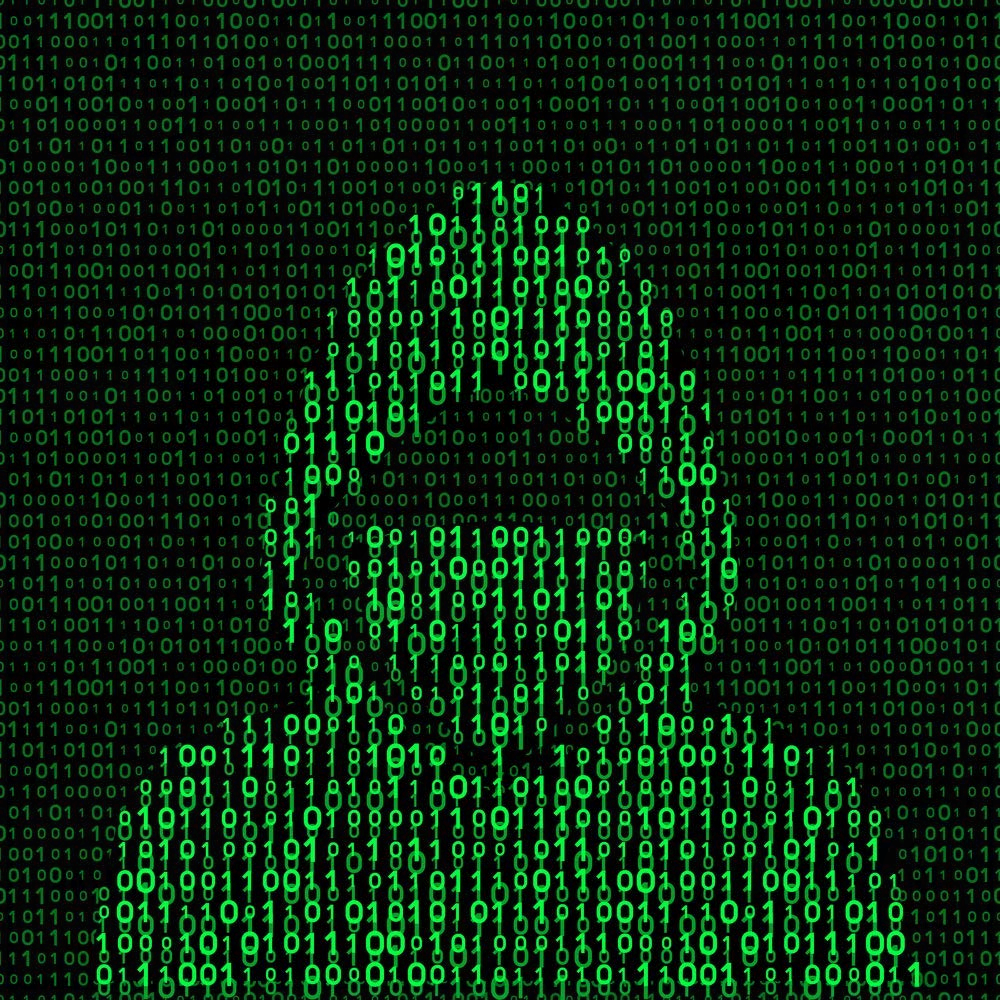

In [40]:
Image.open("Enc.png")

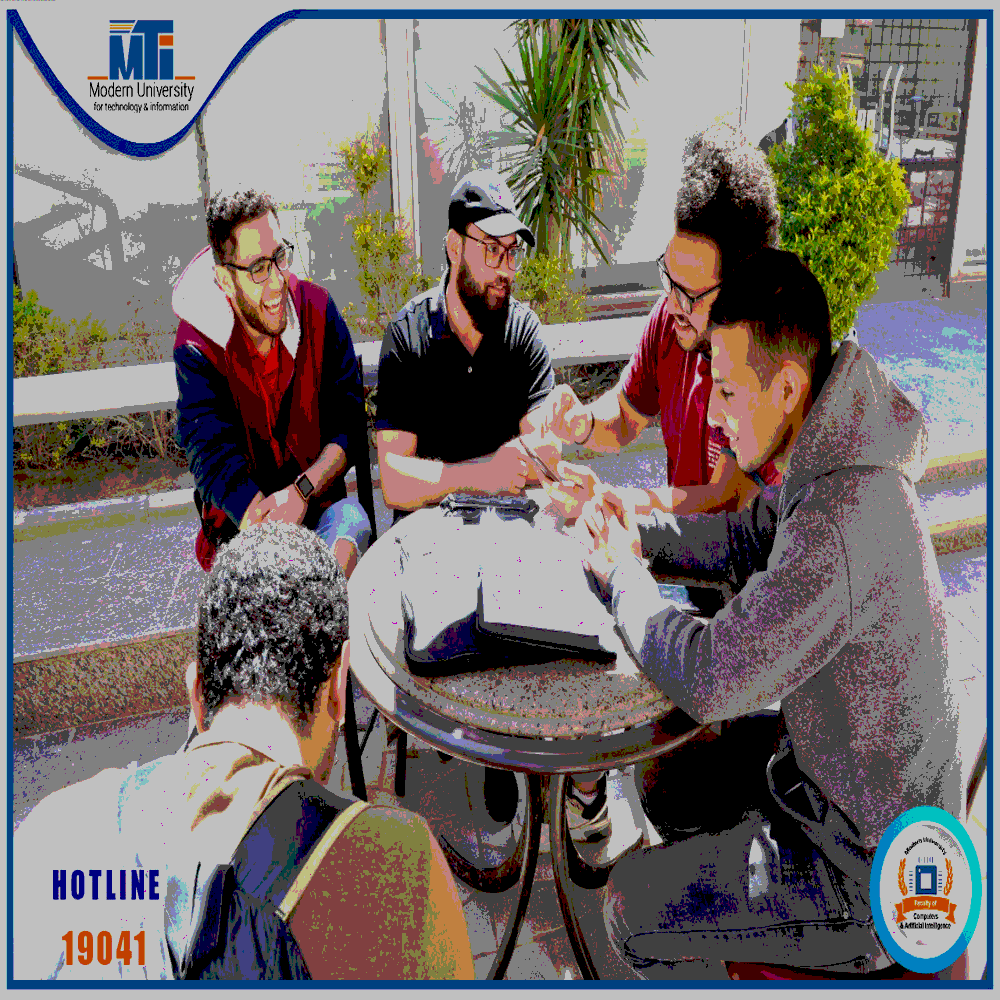

In [41]:
Image.open("Dec.png")

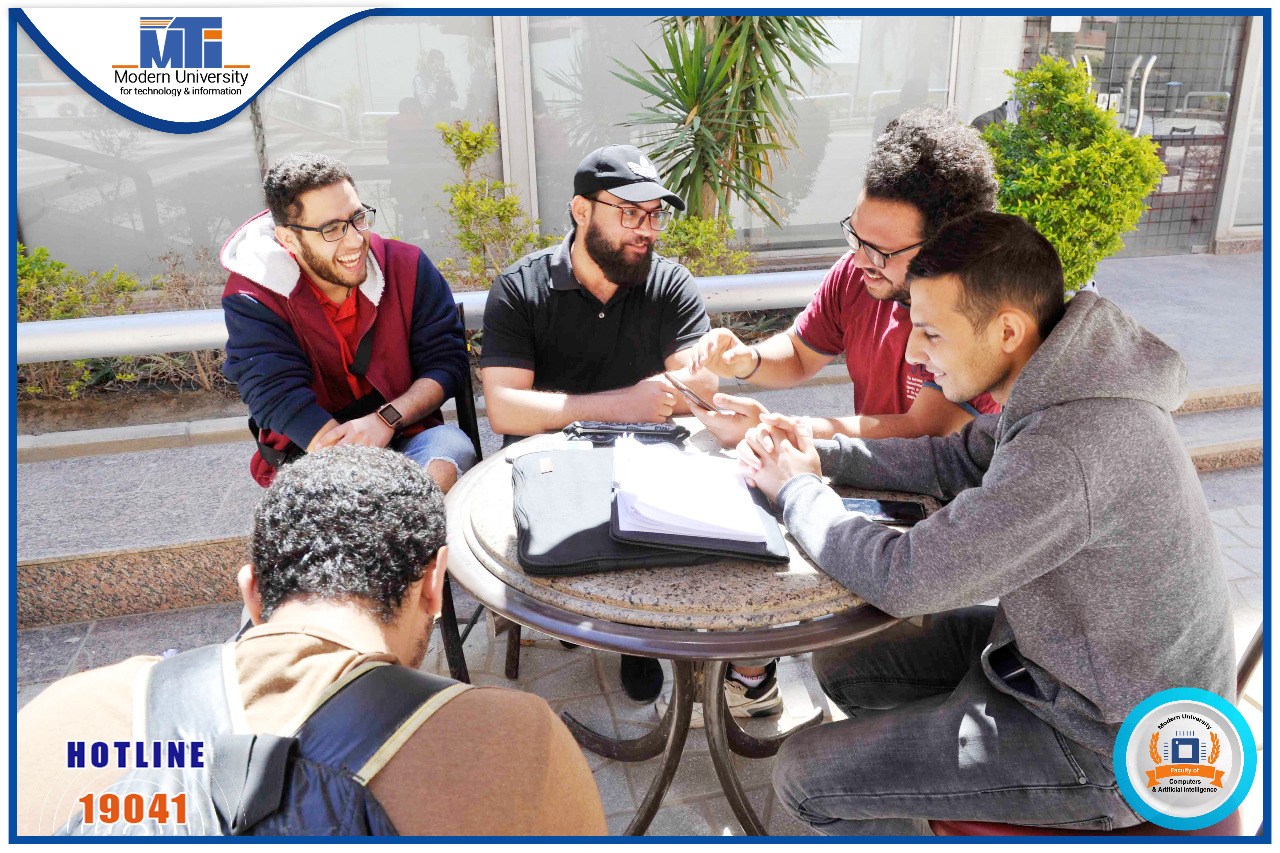

In [42]:
Image.open("Mody.jpg")